In [ ]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/capstone

/content/drive/My Drive/capstone


In [ ]:
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 6.0MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144789 sha256=8e4fad15cff142e066ce2bbd1a32e32e35b6a69b2d53a76f6ee56ae6d6235e7e
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [ ]:
import model as m

import argparse
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
import torchtext.data as data
import random
import matplotlib.pyplot as plt
from tqdm import notebook
from sklearn.model_selection import KFold

### train function

In [ ]:
def train(config, train_iter, model, criterion, optimizer, epoch, dic, save_path, prob=0):
    global iteration, n_total, train_loss, n_bad_loss
    global init, best_val_loss, stop

    print("=> EPOCH {}".format(epoch))
    train_iter.init_epoch()
    for i, batch in notebook.tqdm(enumerate(train_iter), total=len(train_iter)):
        # TODO 
        # add noise to batch
        g = batch.grapheme
        # if random.random() > prob:
         #   g = grapheme_add_noise(0.1, g, dic)
        
        
        iteration += 1
        model.train()
        output, _, __ = model(g, batch.phoneme[:-1].detach())
        target = batch.phoneme[1:]
        # print(output.size())
        loss = criterion(output.view(output.size(0) * output.size(1), -1),
                         target.view(target.size(0) * target.size(1)))
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip, 'inf')
        optimizer.step()
        
        n_total += batch.batch_size
        train_loss += loss.data * batch.batch_size
        
        # print("   % Time: {:5.0f} | Iteration: {:5} | Batch: {:4}/{}"
        #           " | Train loss: {:.4f}"
        #           .format(time.time()-init, iteration, train_iter.iterations,
        #                   len(train_iter), train_loss))
        
        if iteration % config.log_every == 0:
            train_loss /= n_total
            val_loss = validate(val_iter, model, criterion)
            print("   % Time: {:5.0f} | Iteration: {:5} | Batch: {:4}/{}"
                  " | Train loss: {:.4f} | Val loss: {:.4f}"
                  .format(time.time()-init, iteration, train_iter.iterations,
                          len(train_iter), train_loss, val_loss))
            
            # test for val_loss improvement
            n_total = train_loss = 0
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                torch.save(model.state_dict(), save_path)
            else:
                n_bad_loss += 1
            if n_bad_loss == config.n_bad_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                m.adjust_learning_rate(optimizer, config.lr_decay)
                new_lr = optimizer.param_groups[0]['lr']
                print("=> Adjust learning rate to: {}".format(new_lr))
                if new_lr < config.lr_min:
                    stop = True
                    break

### Validation Function

In [ ]:
def validate(val_iter, model, criterion):
    model.eval()
    val_loss = 0
    val_iter.init_epoch()
    for batch in val_iter:
        output, _, __ = model(batch.grapheme, batch.phoneme[:-1])
        target = batch.phoneme[1:]
        loss = criterion(output.squeeze(1), target.squeeze(1))
        val_loss += loss.data * batch.batch_size
    
    return val_loss / len(val_iter.dataset)

### Test Function

In [ ]:
def test(test_iter, model, g_dic, p_dic, print_error=False):
    model.eval()
    test_iter.init_epoch()
    test_per = 0
    wrong = []
    with torch.no_grad():
        for batch in test_iter:
            output = model(batch.grapheme).data.tolist()
            target = batch.phoneme[1:].squeeze(1).data.tolist()
            # calculate per, wer here
            try:
                per = m.phoneme_error_rate(output[:output.index(3) + 1], target)
            except ValueError:
                per = m.phoneme_error_rate(output, target) 

            if per > 0:
                
                tmp = list([g_dic[g] for g in batch.grapheme])
                tmp.reverse()
                wrong.append(tmp)

                if print_error:        
                    print("Grapheme: {}\nTarget: {}\nPrediction: {}\n".format(
                      ''.join(tmp),
                      ' '.join([p_dic[p] for p in target]),
                      ' '.join([p_dic[p] for p in output])))

            test_per += per  # batch_size = 1
        
        test_per = test_per / len(test_iter.dataset) * 100
        print("Phoneme error rate (PER): {:.2f}\n"
              .format(test_per))
    
    return test_per, wrong

In [ ]:
def print_result(model, lines, grapheme, g_dic, p_dic):
    g = grapheme[:-3]
    for line in lines:
        if line.strip().split()[0] == g:
            target = line.strip().split()[1:]

    input = [2]
    for letter in g:
        input.insert(1, g_dic.index(letter))
    input = torch.unsqueeze(torch.LongTensor(input).to("cuda"), 1)
    
    with torch.no_grad():

        output = model(input).data.tolist()

     
    print("Grapheme: {}\nTarget: {}\nPrediction: {}\n".format(
            g, ' '.join(target), ' '.join([p_dic[p] for p in output[:-1]]) ) )

## Set parameter

In [ ]:
parser = {
    'num_row': -1, # modify num_row to -1 if you want to input all data points
    'epochs': 15,
    'batch_size': 128,
    'max_len': 20,  # max length of grapheme/phoneme sequences
    'beam_size': 5,  # size of beam for beam-search
    'd_embed': 30,  # embedding dimension
    'd_hidden': 64,  # hidden dimension
    'attention': True,  # use attention or not
    'log_every': 100,  # number of iterations to log and validate training
    'lr': 0.007,  # initial learning rate
    'lr_decay': 0.5,  # decay lr when not observing improvement in val_loss
    'lr_min': 5e-4,  # stop when lr is too low
    'n_bad_loss': 5,  # number of bad val_loss before decaying
    'clip': 2.3,  # clip gradient, to avoid exploding gradient
    'cuda': True,  # using gpu or not
    'seed': 1234,  # initial seed
}
args = argparse.Namespace(**parser)

In [ ]:
args.cuda = args.cuda and torch.cuda.is_available()

# if not os.path.isdir(args.intermediate_path):
#     os.makedirs(args.intermediate_path)
# if not os.path.isdir(args.data_path):
#     os.makedirs(args.data_path)
#     URL = "https://github.com/cmusphinx/cmudict/archive/master.zip"
#     !wget $URL -O ./data/cmudict.zip
#     !unzip ./data/cmudict.zip -d ./data/
#     !mv ./data/cmudict-master $args.data_path

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

## split the data and build dataloader

In [ ]:
import pandas as pd
import pickle
from sklearn import model_selection

In [ ]:
df = pd.read_csv("filtered_no_stress_freq.csv", index_col=0)

In [ ]:
df.head()

,word,frequency
0,'bout B AW T\n,1
1,'em AH M\n,41
2,'round R AW N D\n,5
3,'tis T IH Z\n,2
4,a AH\n,23195


In [ ]:
kf = KFold(n_splits=10)

In [ ]:
new_df = df.sample(frac=1, random_state=777)
kf.get_n_splits(new_df)

10

In [ ]:
new_df.head()

,word,frequency
11153,fame F EY M\n,18
8225,derived D ER AY V D\n,39
21291,orthodontist AO R TH AH D AA N T AH S T\n,9
14817,humanities HH Y UW M AE N IH T IY Z\n,2
26477,sausage S AO S AH JH\n,1


In [ ]:
# please rerun this line if you need to retrain the model!!!
cv_generator = kf.split(new_df)

In [49]:
e = 1
test_pers = []
for train_index, test_index in cv_generator:
    # data preparation
    print("data preparation for epoch " + str(e))
    train_set, val_set = model_selection.train_test_split(new_df.iloc[train_index,], test_size=0.2222, random_state=args.seed)
    test_set = new_df.iloc[test_index,]
    weight = np.clip(train_set["frequency"].tolist(), 0, 1000)
    np.random.seed(args.seed)
    train_lines = np.random.choice(train_set["word"].tolist(), size=100000, p=(np.array(weight) / sum(weight)) )
    val_lines = val_set["word"].tolist()
    test_lines = test_set["word"].tolist()
    train_iter, val_iter, test_iter, g_field, p_field = m.prepare_data(train_lines, val_lines, test_lines, args)
    dic = g_field.vocab.itos

    # Training
    #set up configuration
    print("Training for epoch " + str(e))
    config = args 
    config.g_size = len(g_field.vocab)
    config.p_size = len(p_field.vocab)
    config.d_hidden = 64 
    save_path = "model_para/cv_" + str(config.d_hidden) + "/best_model_" + str(config.d_hidden) + "_fold_" + str(e) + ".pt"
    
    model = m.G2P(config)
    criterion = nn.NLLLoss()
    if config.cuda:
        model.cuda()
        criterion.cuda()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)  # use Adagrad
    
    # training
    iteration = n_total = train_loss = n_bad_loss = 0
    stop = False
    best_val_loss = 10
    init = time.time()

    # If you want to change epoch, uncomment the following line
    # config.epochs = 10

    for epoch in range(1, config.epochs+1):
        train(config, train_iter, model, criterion, optimizer, epoch, dic, save_path)
        if stop:
            break

    #calculate result
    test_per, mis_classified = test(test_iter, model, g_dic=g_field.vocab.itos, p_dic=p_field.vocab.itos)
    test_pers.append(test_per)

    # update epoch
    e = e + 1

data preparation for epoch 1
Training for epoch 1
=> EPOCH 1


   % Time:    28 | Iteration:   100 | Batch:  100/782 | Train loss: 1.3623 | Val loss: 2.6209
   % Time:    55 | Iteration:   200 | Batch:  200/782 | Train loss: 0.6557 | Val loss: 1.4551
   % Time:    83 | Iteration:   300 | Batch:  300/782 | Train loss: 0.2679 | Val loss: 0.8949
   % Time:   110 | Iteration:   400 | Batch:  400/782 | Train loss: 0.1607 | Val loss: 0.7287
   % Time:   138 | Iteration:   500 | Batch:  500/782 | Train loss: 0.1193 | Val loss: 0.6660
   % Time:   166 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0999 | Val loss: 0.6168
   % Time:   193 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0835 | Val loss: 0.5931

=> EPOCH 2


   % Time:   221 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0720 | Val loss: 0.5663
   % Time:   249 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0642 | Val loss: 0.5680
   % Time:   276 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0629 | Val loss: 0.5928
   % Time:   304 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0584 | Val loss: 0.5701
   % Time:   331 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0555 | Val loss: 0.5503
   % Time:   359 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0501 | Val loss: 0.5500
   % Time:   387 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0502 | Val loss: 0.5501
   % Time:   414 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0480 | Val loss: 0.5133

=> EPOCH 3


   % Time:   442 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0452 | Val loss: 0.5382
   % Time:   470 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0384 | Val loss: 0.5510
   % Time:   497 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0405 | Val loss: 0.5573
   % Time:   525 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0430 | Val loss: 0.5569
   % Time:   552 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0424 | Val loss: 0.5478
=> Adjust learning rate to: 0.0035
   % Time:   580 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0336 | Val loss: 0.4888
   % Time:   608 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0294 | Val loss: 0.4842
   % Time:   635 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0263 | Val loss: 0.4861

=> EPOCH 4


   % Time:   663 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0236 | Val loss: 0.4903
   % Time:   691 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0214 | Val loss: 0.4901
   % Time:   719 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0220 | Val loss: 0.4987
   % Time:   746 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0218 | Val loss: 0.4956
=> Adjust learning rate to: 0.00175
   % Time:   774 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0201 | Val loss: 0.4872
   % Time:   801 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0195 | Val loss: 0.4763
   % Time:   829 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0191 | Val loss: 0.4790
   % Time:   857 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0197 | Val loss: 0.4725

=> EPOCH 5


   % Time:   885 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0172 | Val loss: 0.4754
   % Time:   913 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0152 | Val loss: 0.4838
   % Time:   940 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0144 | Val loss: 0.4824
   % Time:   968 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0156 | Val loss: 0.4872
   % Time:   996 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0165 | Val loss: 0.4844
=> Adjust learning rate to: 0.000875
   % Time:  1024 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0142 | Val loss: 0.4825
   % Time:  1052 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0148 | Val loss: 0.4803
   % Time:  1079 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0145 | Val loss: 0.4837

=> EPOCH 6


   % Time:  1107 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0124 | Val loss: 0.4821
   % Time:  1135 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0120 | Val loss: 0.4811
   % Time:  1163 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0123 | Val loss: 0.4840
   % Time:  1190 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0120 | Val loss: 0.4887
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 13.39

data preparation for epoch 2
Training for epoch 2
=> EPOCH 1


   % Time:    28 | Iteration:   100 | Batch:  100/782 | Train loss: 1.3773 | Val loss: 2.6316
   % Time:    56 | Iteration:   200 | Batch:  200/782 | Train loss: 0.6656 | Val loss: 1.3983
   % Time:    84 | Iteration:   300 | Batch:  300/782 | Train loss: 0.2560 | Val loss: 0.8848
   % Time:   112 | Iteration:   400 | Batch:  400/782 | Train loss: 0.1475 | Val loss: 0.7273
   % Time:   139 | Iteration:   500 | Batch:  500/782 | Train loss: 0.1114 | Val loss: 0.6970
   % Time:   167 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0905 | Val loss: 0.6685
   % Time:   195 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0760 | Val loss: 0.5914

=> EPOCH 2


   % Time:   223 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0707 | Val loss: 0.6090
   % Time:   251 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0598 | Val loss: 0.5948
   % Time:   278 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0569 | Val loss: 0.5917
   % Time:   306 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0541 | Val loss: 0.5846
   % Time:   334 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0518 | Val loss: 0.6105
   % Time:   362 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0501 | Val loss: 0.5953
   % Time:   389 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0457 | Val loss: 0.5801
   % Time:   417 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0461 | Val loss: 0.6049

=> EPOCH 3


   % Time:   445 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0423 | Val loss: 0.5545
   % Time:   473 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0372 | Val loss: 0.5733
   % Time:   501 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0380 | Val loss: 0.5565
   % Time:   528 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0391 | Val loss: 0.5602
   % Time:   556 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0370 | Val loss: 0.5641
   % Time:   584 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0356 | Val loss: 0.5667
=> Adjust learning rate to: 0.0035
   % Time:   612 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0323 | Val loss: 0.5298
   % Time:   640 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0276 | Val loss: 0.5147

=> EPOCH 4


   % Time:   668 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0233 | Val loss: 0.5182
   % Time:   696 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0215 | Val loss: 0.5279
   % Time:   723 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0212 | Val loss: 0.5373
   % Time:   751 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0219 | Val loss: 0.5367
   % Time:   779 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0216 | Val loss: 0.5366
=> Adjust learning rate to: 0.00175
   % Time:   807 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0201 | Val loss: 0.5264
   % Time:   834 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0184 | Val loss: 0.5216
   % Time:   862 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0175 | Val loss: 0.5124

=> EPOCH 5


   % Time:   890 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0149 | Val loss: 0.5195
   % Time:   918 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0142 | Val loss: 0.5168
   % Time:   946 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0140 | Val loss: 0.5277
   % Time:   973 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0150 | Val loss: 0.5325
   % Time:  1001 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0150 | Val loss: 0.5231
=> Adjust learning rate to: 0.000875
   % Time:  1029 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0132 | Val loss: 0.5243
   % Time:  1056 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0138 | Val loss: 0.5236
   % Time:  1084 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0138 | Val loss: 0.5222

=> EPOCH 6


   % Time:  1112 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0104 | Val loss: 0.5261
   % Time:  1139 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0124 | Val loss: 0.5305
   % Time:  1167 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0110 | Val loss: 0.5236
   % Time:  1195 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0120 | Val loss: 0.5271
   % Time:  1222 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0126 | Val loss: 0.5301
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 14.65

data preparation for epoch 3
Training for epoch 3
=> EPOCH 1


   % Time:    28 | Iteration:   100 | Batch:  100/782 | Train loss: 1.3455 | Val loss: 2.4246
   % Time:    55 | Iteration:   200 | Batch:  200/782 | Train loss: 0.5110 | Val loss: 0.9015
   % Time:    83 | Iteration:   300 | Batch:  300/782 | Train loss: 0.2060 | Val loss: 0.6698
   % Time:   110 | Iteration:   400 | Batch:  400/782 | Train loss: 0.1302 | Val loss: 0.5969
   % Time:   137 | Iteration:   500 | Batch:  500/782 | Train loss: 0.1062 | Val loss: 0.6004
   % Time:   165 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0853 | Val loss: 0.5096
   % Time:   192 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0780 | Val loss: 0.5268

=> EPOCH 2


   % Time:   220 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0714 | Val loss: 0.5633
   % Time:   248 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0635 | Val loss: 0.5283
   % Time:   276 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0549 | Val loss: 0.4987
   % Time:   304 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0519 | Val loss: 0.5271
   % Time:   331 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0491 | Val loss: 0.5294
   % Time:   359 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0540 | Val loss: 0.5250
   % Time:   387 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0499 | Val loss: 0.5703
   % Time:   415 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0505 | Val loss: 0.5076
=> Adjust learning rate to: 0.0035

=> EPOCH 3


   % Time:   442 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0371 | Val loss: 0.4698
   % Time:   470 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0307 | Val loss: 0.4608
   % Time:   498 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0301 | Val loss: 0.4854
   % Time:   525 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0302 | Val loss: 0.4938
   % Time:   553 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0266 | Val loss: 0.5092
   % Time:   581 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0284 | Val loss: 0.4827
   % Time:   609 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0276 | Val loss: 0.4845
=> Adjust learning rate to: 0.00175
   % Time:   637 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0248 | Val loss: 0.4681

=> EPOCH 4


   % Time:   666 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0219 | Val loss: 0.4809
   % Time:   694 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0197 | Val loss: 0.4841
   % Time:   722 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0205 | Val loss: 0.4878
   % Time:   750 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0216 | Val loss: 0.4805
   % Time:   779 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0198 | Val loss: 0.4716
=> Adjust learning rate to: 0.000875
   % Time:   807 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0178 | Val loss: 0.4770
   % Time:   835 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0196 | Val loss: 0.4759
   % Time:   863 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0176 | Val loss: 0.4753

=> EPOCH 5


   % Time:   892 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0150 | Val loss: 0.4818
   % Time:   920 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0141 | Val loss: 0.4729
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 12.48

data preparation for epoch 4
Training for epoch 4
=> EPOCH 1


   % Time:    29 | Iteration:   100 | Batch:  100/782 | Train loss: 1.3378 | Val loss: 2.3730
   % Time:    58 | Iteration:   200 | Batch:  200/782 | Train loss: 0.5485 | Val loss: 1.1103
   % Time:    86 | Iteration:   300 | Batch:  300/782 | Train loss: 0.2209 | Val loss: 0.8101
   % Time:   115 | Iteration:   400 | Batch:  400/782 | Train loss: 0.1442 | Val loss: 0.6377
   % Time:   143 | Iteration:   500 | Batch:  500/782 | Train loss: 0.1149 | Val loss: 0.6364
   % Time:   171 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0971 | Val loss: 0.6202
   % Time:   199 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0824 | Val loss: 0.5295

=> EPOCH 2


   % Time:   227 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0729 | Val loss: 0.5126
   % Time:   256 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0648 | Val loss: 0.4956
   % Time:   284 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0565 | Val loss: 0.4841
   % Time:   312 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0590 | Val loss: 0.4968
   % Time:   340 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0541 | Val loss: 0.4926
   % Time:   368 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0528 | Val loss: 0.4958
   % Time:   396 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0496 | Val loss: 0.4826
   % Time:   424 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0483 | Val loss: 0.4959

=> EPOCH 3


   % Time:   452 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0458 | Val loss: 0.4949
   % Time:   480 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0423 | Val loss: 0.4964
   % Time:   509 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0404 | Val loss: 0.4736
   % Time:   537 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0393 | Val loss: 0.4756
   % Time:   565 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0394 | Val loss: 0.4706
   % Time:   593 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0405 | Val loss: 0.4747
   % Time:   621 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0408 | Val loss: 0.4790
   % Time:   649 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0398 | Val loss: 0.4842

=> EPOCH 4


   % Time:   677 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0347 | Val loss: 0.4877
   % Time:   705 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0325 | Val loss: 0.4718
=> Adjust learning rate to: 0.0035
   % Time:   733 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0256 | Val loss: 0.4358
   % Time:   761 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0246 | Val loss: 0.4361
   % Time:   789 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0230 | Val loss: 0.4416
   % Time:   817 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0224 | Val loss: 0.4201
   % Time:   845 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0215 | Val loss: 0.4331
   % Time:   873 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0229 | Val loss: 0.4327

=> EPOCH 5


   % Time:   901 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0202 | Val loss: 0.4413
   % Time:   929 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0174 | Val loss: 0.4459
   % Time:   957 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0182 | Val loss: 0.4447
=> Adjust learning rate to: 0.00175
   % Time:   985 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0173 | Val loss: 0.4455
   % Time:  1013 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0151 | Val loss: 0.4344
   % Time:  1041 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0155 | Val loss: 0.4279
   % Time:  1069 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0145 | Val loss: 0.4267
   % Time:  1097 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0162 | Val loss: 0.4238

=> EPOCH 6


   % Time:  1126 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0120 | Val loss: 0.4247
   % Time:  1154 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0120 | Val loss: 0.4299
   % Time:  1182 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0126 | Val loss: 0.4321
   % Time:  1210 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0121 | Val loss: 0.4382
   % Time:  1238 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0130 | Val loss: 0.4437
=> Adjust learning rate to: 0.000875
   % Time:  1266 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0122 | Val loss: 0.4327
   % Time:  1294 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0110 | Val loss: 0.4370

=> EPOCH 7


   % Time:  1322 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0111 | Val loss: 0.4373
   % Time:  1350 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0088 | Val loss: 0.4414
   % Time:  1378 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0092 | Val loss: 0.4410
   % Time:  1406 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0090 | Val loss: 0.4447
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 12.10

data preparation for epoch 5
Training for epoch 5
=> EPOCH 1


   % Time:    28 | Iteration:   100 | Batch:  100/782 | Train loss: 1.3600 | Val loss: 2.4270
   % Time:    56 | Iteration:   200 | Batch:  200/782 | Train loss: 0.5828 | Val loss: 1.4680
   % Time:    83 | Iteration:   300 | Batch:  300/782 | Train loss: 0.2357 | Val loss: 0.7594
   % Time:   111 | Iteration:   400 | Batch:  400/782 | Train loss: 0.1418 | Val loss: 0.7923
   % Time:   139 | Iteration:   500 | Batch:  500/782 | Train loss: 0.1093 | Val loss: 0.5870
   % Time:   167 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0889 | Val loss: 0.5622
   % Time:   195 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0745 | Val loss: 0.4958

=> EPOCH 2


   % Time:   222 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0707 | Val loss: 0.4951
   % Time:   250 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0581 | Val loss: 0.4994
   % Time:   278 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0557 | Val loss: 0.4834
   % Time:   305 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0522 | Val loss: 0.4822
   % Time:   333 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0534 | Val loss: 0.4835
   % Time:   361 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0498 | Val loss: 0.4666
   % Time:   388 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0488 | Val loss: 0.4846
   % Time:   416 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0507 | Val loss: 0.4874

=> EPOCH 3


   % Time:   444 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0448 | Val loss: 0.4798
   % Time:   472 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0386 | Val loss: 0.5088
   % Time:   500 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0384 | Val loss: 0.4845
=> Adjust learning rate to: 0.0035
   % Time:   528 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0313 | Val loss: 0.4596
   % Time:   556 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0288 | Val loss: 0.4443
   % Time:   583 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0283 | Val loss: 0.4382
   % Time:   611 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0289 | Val loss: 0.4343
   % Time:   639 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0258 | Val loss: 0.4406

=> EPOCH 4


   % Time:   667 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0247 | Val loss: 0.4389
   % Time:   695 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0209 | Val loss: 0.4481
   % Time:   722 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0213 | Val loss: 0.4274
   % Time:   750 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0212 | Val loss: 0.4368
   % Time:   778 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0236 | Val loss: 0.4436
   % Time:   805 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0232 | Val loss: 0.4447
   % Time:   833 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0229 | Val loss: 0.4445
   % Time:   861 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0226 | Val loss: 0.4543
=> Adjust learning rate to: 0.00175

=> EPOCH 5


   % Time:   888 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0183 | Val loss: 0.4357
   % Time:   916 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0175 | Val loss: 0.4228
   % Time:   944 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0146 | Val loss: 0.4302
   % Time:   972 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0153 | Val loss: 0.4395
   % Time:   999 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0159 | Val loss: 0.4332
   % Time:  1027 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0146 | Val loss: 0.4306
   % Time:  1054 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0149 | Val loss: 0.4225
   % Time:  1082 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0144 | Val loss: 0.4369

=> EPOCH 6


   % Time:  1110 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0124 | Val loss: 0.4337
   % Time:  1137 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0120 | Val loss: 0.4360
   % Time:  1164 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0140 | Val loss: 0.4405
   % Time:  1191 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0130 | Val loss: 0.4483
=> Adjust learning rate to: 0.000875
   % Time:  1218 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0121 | Val loss: 0.4446
   % Time:  1245 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0120 | Val loss: 0.4415
   % Time:  1273 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0125 | Val loss: 0.4426

=> EPOCH 7


   % Time:  1300 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0115 | Val loss: 0.4441
   % Time:  1327 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0101 | Val loss: 0.4422
   % Time:  1355 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0099 | Val loss: 0.4469
   % Time:  1382 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0100 | Val loss: 0.4483
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 11.47

data preparation for epoch 6
Training for epoch 6
=> EPOCH 1


   % Time:    28 | Iteration:   100 | Batch:  100/782 | Train loss: 1.3189 | Val loss: 2.4106
   % Time:    55 | Iteration:   200 | Batch:  200/782 | Train loss: 0.5206 | Val loss: 1.3247
   % Time:    82 | Iteration:   300 | Batch:  300/782 | Train loss: 0.2173 | Val loss: 0.7756
   % Time:   109 | Iteration:   400 | Batch:  400/782 | Train loss: 0.1398 | Val loss: 0.6662
   % Time:   136 | Iteration:   500 | Batch:  500/782 | Train loss: 0.1057 | Val loss: 0.5958
   % Time:   163 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0850 | Val loss: 0.6235
   % Time:   191 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0761 | Val loss: 0.5446

=> EPOCH 2


   % Time:   219 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0685 | Val loss: 0.5423
   % Time:   246 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0646 | Val loss: 0.5363
   % Time:   273 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0559 | Val loss: 0.5135
   % Time:   300 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0576 | Val loss: 0.5214
   % Time:   327 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0549 | Val loss: 0.5318
   % Time:   354 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0508 | Val loss: 0.5238
   % Time:   381 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0471 | Val loss: 0.5269
   % Time:   408 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0508 | Val loss: 0.5099

=> EPOCH 3


   % Time:   436 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0477 | Val loss: 0.5228
   % Time:   463 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0386 | Val loss: 0.5188
   % Time:   490 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0397 | Val loss: 0.4885
   % Time:   517 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0366 | Val loss: 0.5367
   % Time:   544 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0384 | Val loss: 0.5059
   % Time:   571 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0412 | Val loss: 0.5158
   % Time:   598 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0391 | Val loss: 0.5126
   % Time:   625 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0360 | Val loss: 0.5018
=> Adjust learning rate to: 0.0035

=> EPOCH 4


   % Time:   653 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0281 | Val loss: 0.4729
   % Time:   680 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0220 | Val loss: 0.4727
   % Time:   707 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0201 | Val loss: 0.4708
   % Time:   734 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0218 | Val loss: 0.4798
   % Time:   761 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0214 | Val loss: 0.4614
   % Time:   787 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0235 | Val loss: 0.4654
   % Time:   814 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0217 | Val loss: 0.4670
   % Time:   841 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0200 | Val loss: 0.4917

=> EPOCH 5


   % Time:   869 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0194 | Val loss: 0.4777
   % Time:   895 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0179 | Val loss: 0.4799
=> Adjust learning rate to: 0.00175
   % Time:   922 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0166 | Val loss: 0.4643
   % Time:   949 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0145 | Val loss: 0.4617
   % Time:   976 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0149 | Val loss: 0.4558
   % Time:  1004 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0149 | Val loss: 0.4612
   % Time:  1032 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0151 | Val loss: 0.4544
   % Time:  1059 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0148 | Val loss: 0.4565

=> EPOCH 6


   % Time:  1087 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0122 | Val loss: 0.4616
   % Time:  1114 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0114 | Val loss: 0.4611
   % Time:  1141 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0110 | Val loss: 0.4580
   % Time:  1168 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0121 | Val loss: 0.4689
=> Adjust learning rate to: 0.000875
   % Time:  1195 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0112 | Val loss: 0.4664
   % Time:  1223 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0108 | Val loss: 0.4645
   % Time:  1250 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0115 | Val loss: 0.4620

=> EPOCH 7


   % Time:  1277 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0096 | Val loss: 0.4673
   % Time:  1304 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0090 | Val loss: 0.4710
   % Time:  1331 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0087 | Val loss: 0.4776
   % Time:  1358 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0084 | Val loss: 0.4751
   % Time:  1385 | Iteration:  5100 | Batch:  408/782 | Train loss: 0.0095 | Val loss: 0.4766
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 12.02

data preparation for epoch 7
Training for epoch 7
=> EPOCH 1


   % Time:    27 | Iteration:   100 | Batch:  100/782 | Train loss: 1.3716 | Val loss: 2.5912
   % Time:    54 | Iteration:   200 | Batch:  200/782 | Train loss: 0.6160 | Val loss: 1.2226
   % Time:    81 | Iteration:   300 | Batch:  300/782 | Train loss: 0.2300 | Val loss: 0.8995
   % Time:   108 | Iteration:   400 | Batch:  400/782 | Train loss: 0.1373 | Val loss: 0.8216
   % Time:   134 | Iteration:   500 | Batch:  500/782 | Train loss: 0.1048 | Val loss: 0.7778
   % Time:   162 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0876 | Val loss: 0.7369
   % Time:   188 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0780 | Val loss: 0.7163

=> EPOCH 2


   % Time:   216 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0684 | Val loss: 0.7004
   % Time:   242 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0568 | Val loss: 0.6852
   % Time:   269 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0532 | Val loss: 0.7007
   % Time:   296 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0507 | Val loss: 0.7168
   % Time:   322 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0494 | Val loss: 0.7004
   % Time:   349 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0490 | Val loss: 0.6931
   % Time:   376 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0467 | Val loss: 0.6790
   % Time:   402 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0452 | Val loss: 0.6600

=> EPOCH 3


   % Time:   429 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0404 | Val loss: 0.6682
   % Time:   456 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0373 | Val loss: 0.6711
   % Time:   483 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0363 | Val loss: 0.7000
   % Time:   509 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0393 | Val loss: 0.6501
   % Time:   535 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0369 | Val loss: 0.6594
   % Time:   562 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0338 | Val loss: 0.6492
   % Time:   589 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0360 | Val loss: 0.6705
   % Time:   615 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0345 | Val loss: 0.6747

=> EPOCH 4


   % Time:   642 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0332 | Val loss: 0.7081
   % Time:   668 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0323 | Val loss: 0.6566
   % Time:   695 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0325 | Val loss: 0.6711
=> Adjust learning rate to: 0.0035
   % Time:   722 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0282 | Val loss: 0.6294
   % Time:   748 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0213 | Val loss: 0.6252
   % Time:   775 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0237 | Val loss: 0.6207
   % Time:   802 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0224 | Val loss: 0.6101
   % Time:   828 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0209 | Val loss: 0.6197

=> EPOCH 5


   % Time:   855 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0193 | Val loss: 0.6129
   % Time:   881 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0167 | Val loss: 0.6256
   % Time:   908 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0160 | Val loss: 0.6184
   % Time:   934 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0161 | Val loss: 0.6172
=> Adjust learning rate to: 0.00175
   % Time:   961 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0169 | Val loss: 0.6100
   % Time:   987 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0145 | Val loss: 0.6008
   % Time:  1013 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0140 | Val loss: 0.6059
   % Time:  1040 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0140 | Val loss: 0.6094

=> EPOCH 6


   % Time:  1066 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0115 | Val loss: 0.6053
   % Time:  1093 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0103 | Val loss: 0.6080
   % Time:  1120 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0109 | Val loss: 0.6107
=> Adjust learning rate to: 0.000875
   % Time:  1146 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0103 | Val loss: 0.6055
   % Time:  1173 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0112 | Val loss: 0.6059
   % Time:  1199 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0112 | Val loss: 0.6117
   % Time:  1226 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0102 | Val loss: 0.6036

=> EPOCH 7


   % Time:  1252 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0093 | Val loss: 0.6085
   % Time:  1279 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0087 | Val loss: 0.6108
   % Time:  1305 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0081 | Val loss: 0.6116
   % Time:  1332 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0093 | Val loss: 0.6209
   % Time:  1358 | Iteration:  5100 | Batch:  408/782 | Train loss: 0.0080 | Val loss: 0.6182
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 17.46

data preparation for epoch 8
Training for epoch 8
=> EPOCH 1


   % Time:    27 | Iteration:   100 | Batch:  100/782 | Train loss: 1.3513 | Val loss: 2.4990
   % Time:    54 | Iteration:   200 | Batch:  200/782 | Train loss: 0.6458 | Val loss: 1.3251
   % Time:    81 | Iteration:   300 | Batch:  300/782 | Train loss: 0.2730 | Val loss: 0.8798
   % Time:   107 | Iteration:   400 | Batch:  400/782 | Train loss: 0.1619 | Val loss: 0.7206
   % Time:   134 | Iteration:   500 | Batch:  500/782 | Train loss: 0.1243 | Val loss: 0.6459
   % Time:   160 | Iteration:   600 | Batch:  600/782 | Train loss: 0.1020 | Val loss: 0.6220
   % Time:   186 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0843 | Val loss: 0.5868

=> EPOCH 2


   % Time:   213 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0760 | Val loss: 0.5819
   % Time:   240 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0658 | Val loss: 0.5789
   % Time:   266 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0638 | Val loss: 0.5617
   % Time:   293 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0594 | Val loss: 0.5896
   % Time:   320 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0596 | Val loss: 0.5583
   % Time:   346 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0571 | Val loss: 0.5417
   % Time:   372 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0546 | Val loss: 0.5626
   % Time:   399 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0483 | Val loss: 0.5546

=> EPOCH 3


   % Time:   426 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0494 | Val loss: 0.5840
   % Time:   453 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0436 | Val loss: 0.5805
   % Time:   479 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0446 | Val loss: 0.5723
=> Adjust learning rate to: 0.0035
   % Time:   506 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0375 | Val loss: 0.5038
   % Time:   532 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0304 | Val loss: 0.4907
   % Time:   559 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0298 | Val loss: 0.4882
   % Time:   585 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0289 | Val loss: 0.4872
   % Time:   612 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0296 | Val loss: 0.4863

=> EPOCH 4


   % Time:   639 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0253 | Val loss: 0.4908
   % Time:   666 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0237 | Val loss: 0.4887
   % Time:   693 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0244 | Val loss: 0.4883
   % Time:   719 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0255 | Val loss: 0.4995
   % Time:   746 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0241 | Val loss: 0.5168
=> Adjust learning rate to: 0.00175
   % Time:   772 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0231 | Val loss: 0.4902
   % Time:   799 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0217 | Val loss: 0.4972
   % Time:   825 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0206 | Val loss: 0.4892

=> EPOCH 5


   % Time:   852 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0189 | Val loss: 0.4934
   % Time:   879 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0172 | Val loss: 0.5021
   % Time:   905 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0172 | Val loss: 0.4976
   % Time:   932 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0164 | Val loss: 0.5064
   % Time:   960 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0170 | Val loss: 0.4988
=> Adjust learning rate to: 0.000875
   % Time:   987 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0169 | Val loss: 0.4924
   % Time:  1013 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0148 | Val loss: 0.4928
   % Time:  1041 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0152 | Val loss: 0.4991

=> EPOCH 6


   % Time:  1068 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0130 | Val loss: 0.4945
   % Time:  1094 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0133 | Val loss: 0.4965
   % Time:  1121 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0140 | Val loss: 0.5043
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 13.42

data preparation for epoch 9
Training for epoch 9
=> EPOCH 1


   % Time:    27 | Iteration:   100 | Batch:  100/782 | Train loss: 1.3467 | Val loss: 2.4247
   % Time:    54 | Iteration:   200 | Batch:  200/782 | Train loss: 0.5955 | Val loss: 1.2606
   % Time:    81 | Iteration:   300 | Batch:  300/782 | Train loss: 0.2385 | Val loss: 0.8626
   % Time:   108 | Iteration:   400 | Batch:  400/782 | Train loss: 0.1458 | Val loss: 0.6989
   % Time:   135 | Iteration:   500 | Batch:  500/782 | Train loss: 0.1107 | Val loss: 0.6778
   % Time:   161 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0893 | Val loss: 0.6328
   % Time:   187 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0755 | Val loss: 0.5874

=> EPOCH 2


   % Time:   214 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0725 | Val loss: 0.6290
   % Time:   241 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0630 | Val loss: 0.5902
   % Time:   267 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0573 | Val loss: 0.6206
   % Time:   294 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0547 | Val loss: 0.5763
   % Time:   320 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0540 | Val loss: 0.5831
   % Time:   346 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0536 | Val loss: 0.5361
   % Time:   373 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0489 | Val loss: 0.5486
   % Time:   399 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0485 | Val loss: 0.5278

=> EPOCH 3


   % Time:   426 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0437 | Val loss: 0.5367
   % Time:   452 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0382 | Val loss: 0.5151
   % Time:   478 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0372 | Val loss: 0.5310
   % Time:   504 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0394 | Val loss: 0.5268
   % Time:   530 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0389 | Val loss: 0.5337
   % Time:   556 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0382 | Val loss: 0.5291
   % Time:   582 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0369 | Val loss: 0.5088
   % Time:   608 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0362 | Val loss: 0.5138

=> EPOCH 4


   % Time:   635 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0366 | Val loss: 0.5166
   % Time:   660 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0320 | Val loss: 0.5115
   % Time:   687 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0328 | Val loss: 0.5486
   % Time:   713 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0334 | Val loss: 0.5454
=> Adjust learning rate to: 0.0035
   % Time:   739 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0270 | Val loss: 0.5093
   % Time:   765 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0236 | Val loss: 0.5016
   % Time:   791 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0238 | Val loss: 0.4961
   % Time:   817 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0222 | Val loss: 0.5048

=> EPOCH 5


   % Time:   843 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0212 | Val loss: 0.4990
   % Time:   869 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0179 | Val loss: 0.4854
   % Time:   896 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0154 | Val loss: 0.4833
   % Time:   921 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0178 | Val loss: 0.5056
   % Time:   947 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0193 | Val loss: 0.4965
   % Time:   973 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0173 | Val loss: 0.4928
   % Time:   999 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0182 | Val loss: 0.5005
   % Time:  1025 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0185 | Val loss: 0.5146
=> Adjust learning rate to: 0.00175

=> EPOCH 6


   % Time:  1051 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0137 | Val loss: 0.4965
   % Time:  1078 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0130 | Val loss: 0.4971
   % Time:  1104 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0122 | Val loss: 0.4957
   % Time:  1129 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0114 | Val loss: 0.4972
   % Time:  1155 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0112 | Val loss: 0.5057
   % Time:  1182 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0126 | Val loss: 0.4994
   % Time:  1207 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0111 | Val loss: 0.5038

=> EPOCH 7


   % Time:  1234 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0120 | Val loss: 0.4893
   % Time:  1260 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0103 | Val loss: 0.5066
   % Time:  1286 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0101 | Val loss: 0.5087
   % Time:  1312 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0107 | Val loss: 0.5097
   % Time:  1338 | Iteration:  5100 | Batch:  408/782 | Train loss: 0.0106 | Val loss: 0.5227
   % Time:  1365 | Iteration:  5200 | Batch:  508/782 | Train loss: 0.0096 | Val loss: 0.5205
=> Adjust learning rate to: 0.000875
   % Time:  1391 | Iteration:  5300 | Batch:  608/782 | Train loss: 0.0094 | Val loss: 0.5157
   % Time:  1418 | Iteration:  5400 | Batch:  708/782 | Train loss: 0.0093 | Val loss: 0.5143

=> EPOCH 8


   % Time:  1444 | Iteration:  5500 | Batch:   26/782 | Train loss: 0.0093 | Val loss: 0.5147
   % Time:  1470 | Iteration:  5600 | Batch:  126/782 | Train loss: 0.0075 | Val loss: 0.5116
   % Time:  1497 | Iteration:  5700 | Batch:  226/782 | Train loss: 0.0082 | Val loss: 0.5174
   % Time:  1523 | Iteration:  5800 | Batch:  326/782 | Train loss: 0.0075 | Val loss: 0.5181
   % Time:  1549 | Iteration:  5900 | Batch:  426/782 | Train loss: 0.0076 | Val loss: 0.5235
   % Time:  1575 | Iteration:  6000 | Batch:  526/782 | Train loss: 0.0076 | Val loss: 0.5217
   % Time:  1601 | Iteration:  6100 | Batch:  626/782 | Train loss: 0.0081 | Val loss: 0.5209
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 13.95

data preparation for epoch 10
Training for epoch 10
=> EPOCH 1


   % Time:    27 | Iteration:   100 | Batch:  100/782 | Train loss: 1.3708 | Val loss: 2.4500
   % Time:    53 | Iteration:   200 | Batch:  200/782 | Train loss: 0.6240 | Val loss: 1.2186
   % Time:    79 | Iteration:   300 | Batch:  300/782 | Train loss: 0.2383 | Val loss: 0.8526
   % Time:   105 | Iteration:   400 | Batch:  400/782 | Train loss: 0.1445 | Val loss: 0.7237
   % Time:   131 | Iteration:   500 | Batch:  500/782 | Train loss: 0.1114 | Val loss: 0.6533
   % Time:   157 | Iteration:   600 | Batch:  600/782 | Train loss: 0.0935 | Val loss: 0.6331
   % Time:   183 | Iteration:   700 | Batch:  700/782 | Train loss: 0.0792 | Val loss: 0.6294

=> EPOCH 2


   % Time:   210 | Iteration:   800 | Batch:   18/782 | Train loss: 0.0703 | Val loss: 0.6304
   % Time:   236 | Iteration:   900 | Batch:  118/782 | Train loss: 0.0624 | Val loss: 0.6232
   % Time:   263 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.0564 | Val loss: 0.6173
   % Time:   289 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0573 | Val loss: 0.6141
   % Time:   315 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0532 | Val loss: 0.6035
   % Time:   342 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0527 | Val loss: 0.6086
   % Time:   369 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0494 | Val loss: 0.5726
   % Time:   395 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0507 | Val loss: 0.5792

=> EPOCH 3


   % Time:   422 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0430 | Val loss: 0.5856
   % Time:   448 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0403 | Val loss: 0.5810
   % Time:   474 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0406 | Val loss: 0.6077
   % Time:   499 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0409 | Val loss: 0.5612
   % Time:   525 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0433 | Val loss: 0.5858
   % Time:   551 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0401 | Val loss: 0.5972
   % Time:   577 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0384 | Val loss: 0.5856
   % Time:   603 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0363 | Val loss: 0.5940

=> EPOCH 4


   % Time:   629 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0342 | Val loss: 0.5718
=> Adjust learning rate to: 0.0035
   % Time:   656 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0261 | Val loss: 0.5452
   % Time:   682 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0244 | Val loss: 0.5287
   % Time:   708 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0238 | Val loss: 0.5353
   % Time:   733 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0232 | Val loss: 0.5567
   % Time:   759 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0230 | Val loss: 0.5550
   % Time:   785 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0220 | Val loss: 0.5428
   % Time:   810 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0238 | Val loss: 0.5448
=> Adjust learning rate to: 0.00175

=> EPOCH 5


   % Time:   837 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0180 | Val loss: 0.5408
   % Time:   863 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0143 | Val loss: 0.5383
   % Time:   889 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0157 | Val loss: 0.5519
   % Time:   915 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0155 | Val loss: 0.5375
   % Time:   941 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0143 | Val loss: 0.5517
   % Time:   966 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0147 | Val loss: 0.5541
   % Time:   992 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0154 | Val loss: 0.5637
   % Time:  1018 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0147 | Val loss: 0.5558

=> EPOCH 6


   % Time:  1044 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0127 | Val loss: 0.5588
=> Adjust learning rate to: 0.000875
   % Time:  1069 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0115 | Val loss: 0.5542
   % Time:  1095 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0118 | Val loss: 0.5652
   % Time:  1120 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0116 | Val loss: 0.5655
   % Time:  1146 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0117 | Val loss: 0.5603
   % Time:  1171 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0110 | Val loss: 0.5567
   % Time:  1197 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0116 | Val loss: 0.5625
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 15.60



Text(0, 0.5, 'PER')

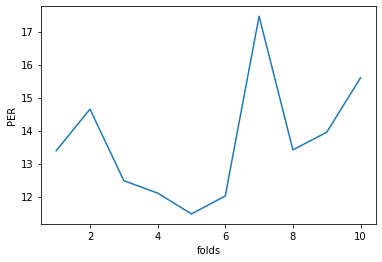

In [51]:
plt.plot(np.arange(1,11), test_pers)
plt.xlabel("folds")
plt.ylabel("PER")

In [52]:
print(np.mean(test_pers))

13.654124558248967


In [53]:
print(np.std(test_pers))

1.7526220750075252


In [54]:
test_pers

[13.387818656388959,
 14.648446424239994,
 12.48182952327563,
 12.104833683835581,
 11.473760311558792,
 12.016464672045107,
 17.464639485022833,
 13.415688047781444,
 13.9486068650933,
 15.599157913248046]

In [56]:
np.mean(test_pers) + np.std(test_pers)

15.406746633256493